In [1]:
import pandas as pd
#import requests
#from bs4 import BeautifulSoup
#from tqdm.notebook import tqdm
import re
import random
from fuzzywuzzy import fuzz, process
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
import seaborn as sn
import plotly

In [2]:
arrests=pd.read_csv('USArrests.csv')

In [3]:
arrests

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


In [4]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [5]:
arrests.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


array([[<AxesSubplot:title={'center':'Murder'}>,
        <AxesSubplot:title={'center':'Assault'}>],
       [<AxesSubplot:title={'center':'UrbanPop'}>,
        <AxesSubplot:title={'center':'Rape'}>]], dtype=object)

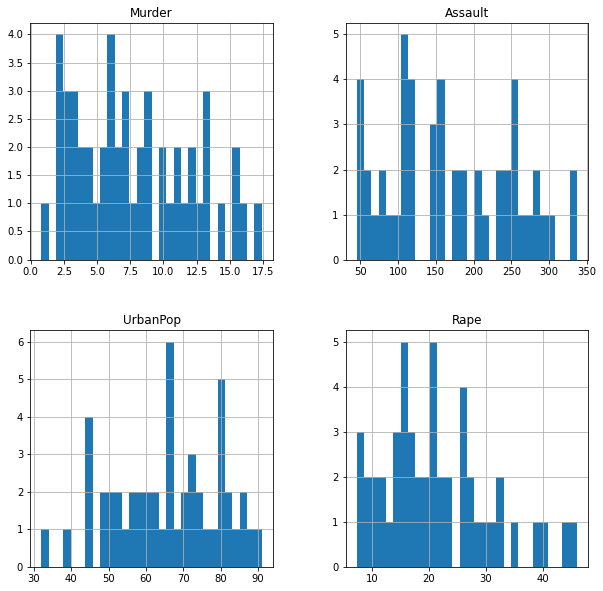

In [6]:
arrests.hist(bins=30, figsize=(10,10))

## prepare for K means

In [7]:
# move first column to index


arrests.index=arrests.iloc[:,0]

#iloc funciona iloc[ localizacion-de-rows, localizacion-de-columns]

In [8]:
#dropeamos la primera columna que ya no nos sirve
#iloc [rows , columns]
arrests=arrests.iloc[:,1:5]

In [9]:
arrests

,Murder,Assault,UrbanPop,Rape
Unnamed: 0,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9


In [10]:
arrests.rename_axis(None, inplace=True)

In [11]:
arrests

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9
Georgia,17.4,211,60,25.8


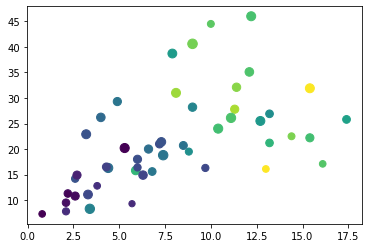

In [12]:
plt.scatter(arrests.iloc[:,0],arrests.iloc[:,3],arrests.iloc[:,2],arrests.iloc[:,1]) #x y size color

## lets try cluster

In [13]:
kmeans=KMeans(n_clusters=8, random_state=42)

In [14]:
#hacemos que calcule los clusters
cluster=kmeans.fit(arrests)

In [15]:
cluster.cluster_centers_

array([[ 13.5       , 267.        ,  46.66666667,  28.03333333],
       [  5.59      , 112.4       ,  65.6       ,  17.27      ],
       [  2.95      ,  62.7       ,  53.9       ,  11.51      ],
       [  6.11111111, 159.11111111,  73.55555556,  20.37777778],
       [ 14.2       , 336.        ,  62.5       ,  24.        ],
       [ 11.47142857, 247.57142857,  74.28571429,  27.2       ],
       [ 12.        , 198.8       ,  65.4       ,  27.28      ],
       [  9.95      , 288.75      ,  77.        ,  32.875     ]])

In [16]:
cluster.labels_

array([5, 0, 7, 6, 7, 6, 1, 5, 4, 6, 2, 1, 5, 1, 2, 1, 1, 5, 2, 7, 3, 5,
       2, 0, 3, 1, 1, 5, 2, 3, 7, 5, 4, 2, 1, 3, 3, 1, 3, 0, 2, 6, 6, 1,
       2, 3, 3, 2, 2, 3])

In [17]:
arrests['cluster']= cluster.labels_

In [18]:
arrests

,Murder,Assault,UrbanPop,Rape,cluster
Alabama,13.2,236,58,21.2,5
Alaska,10.0,263,48,44.5,0
Arizona,8.1,294,80,31.0,7
Arkansas,8.8,190,50,19.5,6
California,9.0,276,91,40.6,7
Colorado,7.9,204,78,38.7,6
Connecticut,3.3,110,77,11.1,1
Delaware,5.9,238,72,15.8,5
Florida,15.4,335,80,31.9,4
Georgia,17.4,211,60,25.8,6


In [19]:
arrests['cluster'].value_counts()

1    10
2    10
3     9
5     7
6     5
7     4
0     3
4     2
Name: cluster, dtype: int64

## visualisation

In [20]:
import plotly.graph_objs as go

In [21]:
#construimos nuestro plot en 3D
#para cambiar los colores hay que cambiar el colorscale --> https://plotly.com/python/builtin-colorscales/

markersize= arrests['UrbanPop']
markercolour= arrests['cluster']
fig1=go.Scatter3d(x=arrests['Murder'],
                  y=arrests['Rape'],
                  z=arrests['Assault'],
                 marker=dict (size=markersize,
                              color=markercolour,
                              opacity=0.9,
                              colorscale='Turbo'),
                 line=dict (width=0.2),
                 mode='markers')
#make layout
mylayout=go.Layout(scene=dict(xaxis=dict(title='Murder'),
                              yaxis=dict(title='Rape'),
                              zaxis=dict(title='Assault')))

In [22]:
plotly.offline.plot({'data':[fig1],
                    'layout':mylayout},
                   auto_open=True,
                   filename=('5Dplot.html'))

'5Dplot.html'

## scale before clustering

In [23]:
#drop cluster
arrests.drop(['cluster'], axis=1, inplace=True)

In [24]:
arrests

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9
Georgia,17.4,211,60,25.8


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler2= StandardScaler()
scaler=MinMaxScaler()

scaler.fit(arrests)

MinMaxScaler()

In [26]:
sclaed_arrests=scaler.transform(arrests)

In [27]:
arrests.columns


Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

In [28]:
scaled_arrests_df=pd.DataFrame(sclaed_arrests, columns=['Murder', 'Assault', 'UrbanPop', 'Rape'])

In [29]:
scaled_arrests_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.000000,50.000000,50.000000,50.000000
mean,0.420964,0.430685,0.568475,0.360000
std,0.262380,0.285403,0.245335,0.242025
min,0.000000,0.000000,0.000000,0.000000
25%,0.197289,0.219178,0.381356,0.200904
50%,0.388554,0.390411,0.576271,0.330749
75%,0.629518,0.698630,0.775424,0.487726
max,1.000000,1.000000,1.000000,1.000000


In [30]:
cluster=kmeans.fit(scaled_arrests_df)

In [31]:
cluster.labels_

array([7, 6, 2, 3, 0, 0, 5, 3, 2, 7, 5, 1, 2, 3, 1, 3, 3, 7, 1, 2, 5, 2,
       1, 4, 3, 3, 3, 0, 1, 5, 2, 2, 4, 1, 3, 3, 3, 3, 5, 4, 1, 7, 2, 5,
       1, 3, 3, 1, 1, 3])

In [32]:
scaled_arrests_df['cluster']= cluster.labels_

In [33]:
scaled_arrests_df

,Murder,Assault,UrbanPop,Rape,cluster
0,0.746988,0.654110,0.440678,0.359173,7
1,0.554217,0.746575,0.271186,0.961240,6
2,0.439759,0.852740,0.813559,0.612403,2
3,0.481928,0.496575,0.305085,0.315245,3
4,0.493976,0.791096,1.000000,0.860465,0
5,0.427711,0.544521,0.779661,0.811370,0
6,0.150602,0.222603,0.762712,0.098191,5
7,0.307229,0.660959,0.677966,0.219638,3
8,0.879518,0.993151,0.813559,0.635659,2
9,1.000000,0.568493,0.474576,0.478036,7


In [34]:
#construimos nuestro plot en 3D
#para cambiar los colores hay que cambiar el colorscale --> https://plotly.com/python/builtin-colorscales/

markersize= scaled_arrests_df['UrbanPop']
markercolour= scaled_arrests_df['cluster']
fig1=go.Scatter3d(x=scaled_arrests_df['Murder'],
                  y=scaled_arrests_df['Rape'],
                  z=scaled_arrests_df['Assault'],
                 marker=dict (
                              color=markercolour,
                              opacity=0.9,
                              colorscale='Turbo'),
                 line=dict (width=0.2),
                 mode='markers')
#make layout
mylayout=go.Layout(scene=dict(xaxis=dict(title='Murder'),
                              yaxis=dict(title='Rape'),
                              zaxis=dict(title='Assault')))

In [35]:
plotly.offline.plot({'data':[fig1],
                    'layout':mylayout},
                   auto_open=True,
                   filename=('5Dplot.html'))

'5Dplot.html'

In [36]:
#rule of thumb --clusters= la raiz cuadrada de  N entradas que hay en el df

## pick right numb of clusters

In [37]:
cluster.inertia_

2.30474654408108

In [38]:
#una funcion que va probando diferente numero de clusters y mira su inertia

K=range(3,15)
inertia=[]
for k in K:
    kmeans=KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_arrests_df)
    inertia.append(kmeans.inertia_)


In [39]:
import numpy as np

Text(0.5, 1.0, 'elbow method - finding the optimal k by inertia')

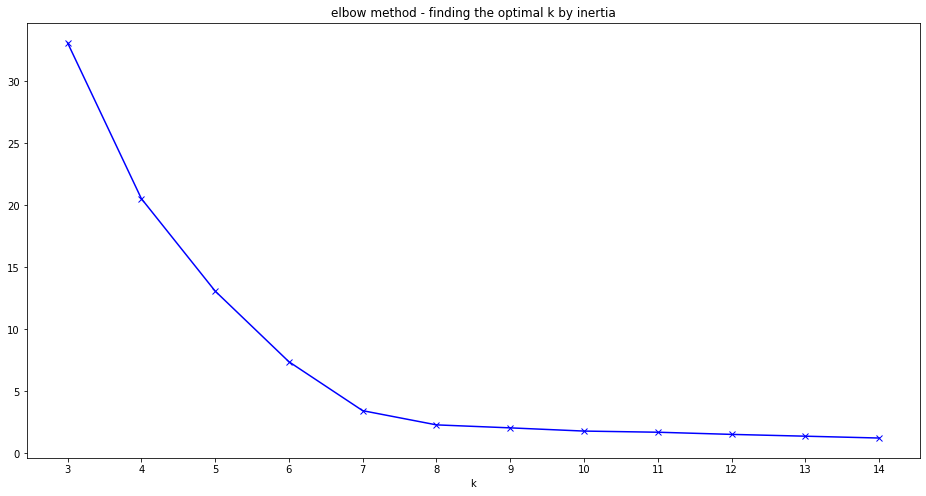

In [40]:
### plot the inertia -- metodo elbow

plt.figure(figsize=(16,8))
plt.plot(K,inertia,'bx-')
plt.xlabel('k')
plt.xticks(np.arange(min(K),max(K)+1,1.0))
plt.title('elbow method - finding the optimal k by inertia')

In [41]:
from sklearn.metrics import silhouette_score

In [42]:
K=range(3,9)
silo=[]

for k in K:
    kmeans=KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_arrests_df)
    silo.append(silhouette_score(scaled_arrests_df,kmeans.predict(scaled_arrests_df)))

Text(0.5, 1.0, ' finding the optimal k by silhouette')

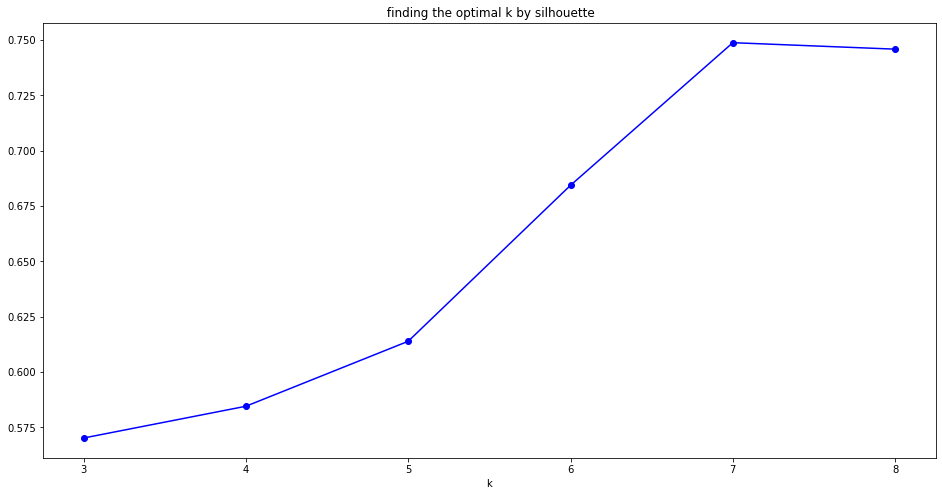

In [43]:
### plot the siluetas/distortion -- metodo elbow

plt.figure(figsize=(16,8))
plt.plot(K,silo,'bo-')
plt.xlabel('k')
plt.xticks(np.arange(min(K),max(K)+1,1.0))
plt.title(' finding the optimal k by silhouette')

#definition
#1-cluster are well apart
#0 - clusters are indiferent - distance between them is not significat
#-1 -clusters are assigned incorrectly -mergin of clusters

## use the results

In [44]:
# re run k means with the right numbre of clusters
#add label into data frame
#introduce new row to see what results we get ( remember to use the same scaler)

In [45]:
arrests.columns

Index(['Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

In [46]:
pau_st={'Murder':3,'Assault':41,'UrbanPop':20,'Rape':14}

In [47]:
#convertimos en data frame

paudf=pd.DataFrame.from_dict([pau_st])

In [48]:
#scale our data
pauscaled=scaler.transform(paudf)

In [49]:
#make it back to df fomr


pauscaled_df=pd.DataFrame(pauscaled, columns=['Murder', 'Assault', 'UrbanPop', 'Rape'])


In [54]:
#esto en realidad ya lo habiamos hecho
#se tratra de tener un modelo entrenado que sea capaz de decir que tal cosa es de X cluster

#como ya teniamos añadido el cluster a los rows hay que quitarlo del df que nos sirve para entrenar
scaled_arrests_df.drop(['cluster'], axis = 1, inplace = True)

kmeans=KMeans(n_clusters=7, random_state=42)

kmeans.fit(scaled_arrests_df)

KMeans(n_clusters=7, random_state=42)

In [55]:
scaled_arrests_df

,Murder,Assault,UrbanPop,Rape
0,0.746988,0.654110,0.440678,0.359173
1,0.554217,0.746575,0.271186,0.961240
2,0.439759,0.852740,0.813559,0.612403
3,0.481928,0.496575,0.305085,0.315245
4,0.493976,0.791096,1.000000,0.860465
5,0.427711,0.544521,0.779661,0.811370
6,0.150602,0.222603,0.762712,0.098191
7,0.307229,0.660959,0.677966,0.219638
8,0.879518,0.993151,0.813559,0.635659
9,1.000000,0.568493,0.474576,0.478036


In [53]:
pauscaled_df

,Murder,Assault,UrbanPop,Rape
0,0.13253,-0.013699,-0.20339,0.173127


In [56]:
kmeans.predict(pauscaled_df)

array([3])